In [1]:
import os

os.getcwd()
os.chdir("../../")
os.getcwd()

'/data01/dl23vitcas/dl_project'

In [2]:
import sys
import argparse

sys.argv = ["view", "--config", "config/single_task_object_detection.yaml"]

parser = argparse.ArgumentParser()
parser.add_argument("--config", type=str, required=True, help="Path to the config file")
args = parser.parse_args()

print(args.config)

config/single_task_object_detection.yaml


In [3]:
from dataloader import VOC08Attr
from torchvision.transforms import transforms
from config_experiments import config

In [4]:
train_data = VOC08Attr(
    train=True,
    transform=transforms.Compose(
        [
            transforms.Resize(
                size=config["transform"]["resize_values"],
                max_size=config["transform"]["max_size"],
            ),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=config["transform"]["mean"], std=config["transform"]["std"]
            ),
        ]
    ),
)

In [5]:
import torch
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
import numpy as np


def show(imgs):
    plt.rcParams["savefig.bbox"] = "tight"
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)  # (H, W)
        axs[0, i].imshow(np.asarray(img))  # (W, H, 3)
        # axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]) # uncomment to remove axis in plot


def show_bounding_box(img_tensor, box, labels=None, color="white"):
    img_tensor = inverse_transform(img_tensor)
    show(draw_bounding_boxes(img_tensor, box, colors=color, labels=labels, width=1))


def show_bbox_with_transform(image, box, mean, std, labels=None, color="white"):
    image = np.array(image)
    for channel in range(3):
        image[channel] = image[channel] * std[channel] + mean[channel]
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    image = torch.from_numpy(image)
    show(draw_bounding_boxes(image, box, colors=color, labels=labels, width=2))


def inverse_transform(image):
    image = np.array(image)
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    image = torch.from_numpy(image)
    return image

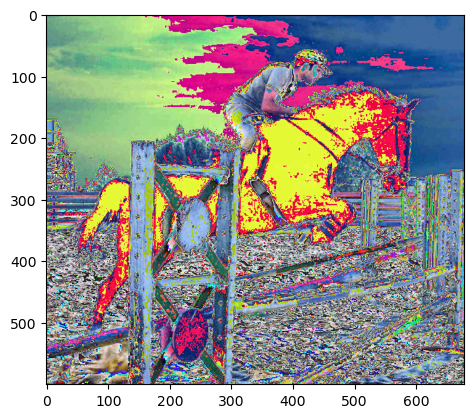

In [6]:
image, img_size, gt_class, gt_bbox, gt_attributes, ss_rois = train_data[0]
show(image)

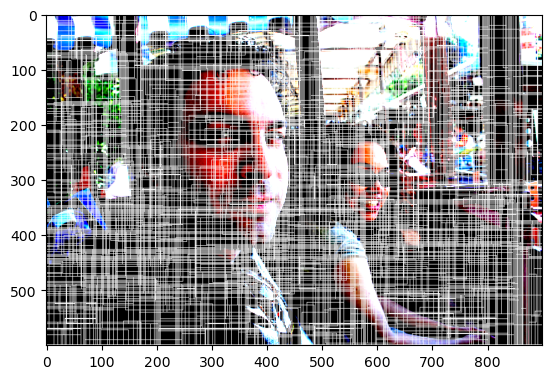

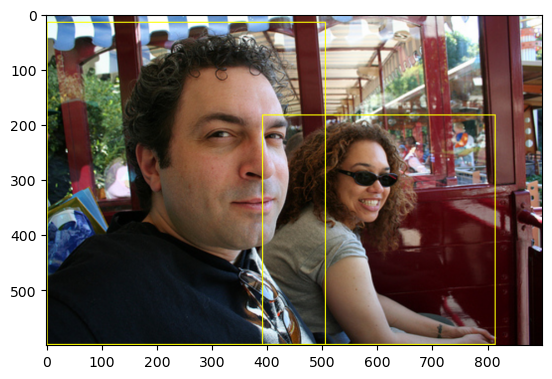

In [7]:
image, img_size, gt_class, gt_bbox, gt_attributes, ss_rois = train_data[300]
show_bounding_box(image, ss_rois)
show_bbox_with_transform(
    image,
    gt_bbox,
    mean=config["transform"]["mean"],
    std=config["transform"]["std"],
    color="yellow",
)

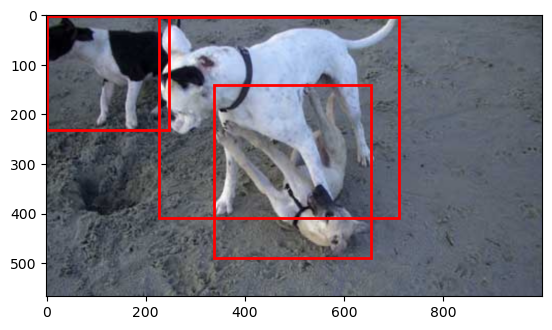

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# Funzione per denormalizzare l'immagine
def denormalize(image, mean, std):
    image = image.clone()
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    return image


# Funzione per visualizzare l'immagine con i bounding box
def show_image_with_boxes(image_tensor, boxes, mean, std):
    # Denormalizzare l'immagine
    image = denormalize(image_tensor, mean, std)
    image = image.numpy().transpose((1, 2, 0))  # Convertire da (C, H, W) a (H, W, C)

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Aggiungere i bounding box
    for box in boxes:
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle(
            (x1, y1), width, height, linewidth=2, edgecolor="r", facecolor="none"
        )
        ax.add_patch(rect)

    plt.show()


# Esempio di utilizzo
image, img_size, gt_class, gt_bbox, gt_attributes, ss_rois = train_data[2]
mean = [0.485, 0.456, 0.406]  # Media di normalizzazione usata
std = [0.229, 0.224, 0.225]  # Deviazione standard di normalizzazione usata

show_image_with_boxes(image, gt_bbox, mean, std)

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_data,
    batch_size=config["preprocessing"]["n_images"],
    collate_fn=train_data.collate_fn,
)

In [10]:
image, train_roi, train_cls, train_offset, _, indices_batch = next(
    iter(train_dataloader)
)

In [11]:
# Funzione per visualizzare un batch di immagini con i bounding box in una singola figura orizzontalmente
def show_batch_with_boxes(images, rois, indices_batch, mean, std):
    batch_size = images.size(0)
    cols = batch_size  # Numero di colonne è uguale alla dimensione del batch (tutte le immagini in una riga)

    fig, axes = plt.subplots(1, cols, figsize=(5 * cols, 5))
    axes = (
        axes.flatten() if batch_size > 1 else [axes]
    )  # Assicurarsi che 'axes' sia una lista

    # Raggruppare i bounding box per immagine
    boxes_per_image = {i: [] for i in range(batch_size)}
    for idx, box in zip(indices_batch.squeeze(), rois):
        boxes_per_image[idx.item()].append(box)

    # Visualizzare ogni immagine con i suoi bounding box
    for i in range(batch_size):
        image = images[i]
        boxes = boxes_per_image[i]

        # Denormalizzare l'immagine
        image = denormalize(image, mean, std)
        image = image.numpy().transpose(
            (1, 2, 0)
        )  # Convertire da (C, H, W) a (H, W, C)

        ax = axes[i]
        ax.imshow(image)
        ax.axis("off")

        # Aggiungere i bounding box
        for box in boxes:
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            rect = patches.Rectangle(
                (x1, y1), width, height, linewidth=2, edgecolor="r", facecolor="none"
            )
            ax.add_patch(rect)

    plt.tight_layout()
    plt.show()

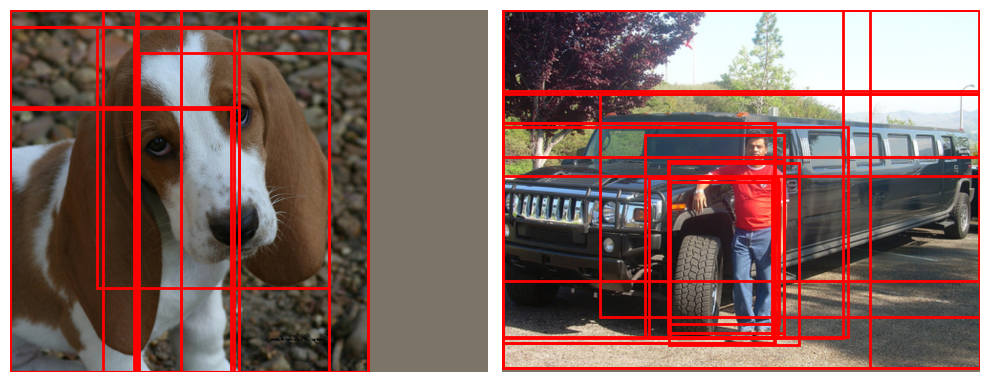

In [12]:
ind = torch.randint(0, 100, (1,)).item()

for i, (image, train_roi, train_cls, train_offset, _, indices_batch) in enumerate(
    train_dataloader
):
    if i == ind:
        pos_index = train_cls > 0
        show_batch_with_boxes(image, train_roi[pos_index], indices_batch, mean, std)

        break

In [13]:
import torchvision
import torch
import torch.nn as nn
from torchvision.models import AlexNet_Weights
from config_experiments import config
from bbox_transform import regr_to_bbox


class Backbone(nn.Module):
    def __init__(self):
        super(Backbone, self).__init__()
        self.rawnet = torchvision.models.alexnet(weights=AlexNet_Weights.DEFAULT)
        self.features = nn.Sequential(*list(self.rawnet.features.children())[:-1])

    def forward(self, input):
        return self.features(input)


class ROI_Module(nn.Module):
    def __init__(self):
        super(ROI_Module, self).__init__()

        self.roipool = torchvision.ops.RoIPool(
            output_size=(6, 6),
            spatial_scale=config["model"]["spatial_scale"],
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(
                256 * 6 * 6,
                4096,
            ),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
        )

    def forward(self, features, rois, ridx):
        idx_rois = torch.cat(
            (ridx, rois), dim=-1
        )  # create matrix with (batch_idx, rois(xyxy))
        res = self.roipool(features, idx_rois)
        res = res.view(res.size(0), -1)
        feat = self.classifier(res)
        return feat


class ObjectDetectionHead(nn.Module):
    def __init__(self, num_classes=config["global"]["num_classes"]):
        super().__init__()
        self.num_classes = num_classes

        self.cls_score = nn.Linear(4096, self.num_classes + 1)
        self.bbox = nn.Linear(4096, 4 * (self.num_classes + 1))

        nn.init.normal_(self.cls_score.weight, mean=0, std=0.01)
        nn.init.normal_(self.bbox.weight, mean=0, std=0.001)
        nn.init.constant_(self.cls_score.bias, 0)
        nn.init.constant_(self.bbox.bias, 0)

    def forward(self, feat):
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat).view(-1, self.num_classes + 1, 4)
        return cls_score, bbox


class ObjectDetectionModel(nn.Module):
    def __init__(
        self,
    ):
        super().__init__()
        self.alex = Backbone()
        self.roi_module = ROI_Module()
        self.obj_detect_head = ObjectDetectionHead(
            num_classes=config["global"]["num_classes"]
        )

    def forward(self, x, rois, ridx):
        out = self.alex(x)
        out = self.roi_module(out, rois, ridx)
        cls_score, bbox = self.obj_detect_head(out)
        return cls_score, bbox

    def prediction_img(self, img, rois, ridx, mean_std_by_class):
        # self.eval()
        score, tbbox = self(img, rois, ridx)
        _, _, heigth, width = img.shape
        score = nn.functional.softmax(score, dim=-1)
        max_score, cls_max_score = torch.max(score, dim=-1)
        bboxs = regr_to_bbox(
            proposals=rois,
            regr=tbbox,
            image_size=(heigth, width),
            mean_std_by_class=mean_std_by_class,
            classes=cls_max_score,
        )  # bbox relative
        classes = cls_max_score.view(-1, 1, 1).expand(cls_max_score.size(0), 1, 4)
        bboxs = bboxs.gather(1, classes).squeeze(1)
        return cls_max_score, max_score, bboxs

    def calc_loss(
        self,
        probs,
        bbox,
        labels,
        gt_bbox,
    ):
        # self.train()
        cel = nn.CrossEntropyLoss()
        sl1 = nn.SmoothL1Loss()
        loss_sc = cel(probs, labels)
        lbl = labels.view(-1, 1, 1).expand(
            labels.size(0), 1, 4
        )  # view --> 128,1,1 expand --> 128, 1, 4
        # ignore background
        mask = (labels != 0).float().view(-1, 1).expand(labels.size(0), 4)
        loss_loc = sl1(bbox.gather(1, lbl).squeeze(1) * mask, gt_bbox * mask)

        loss_sc = config["loss"]["lmb_cls"] * loss_sc
        loss_loc = config["loss"]["lmb_loc"] * loss_loc
        loss = loss_sc + loss_loc
        return loss, loss_sc, loss_loc

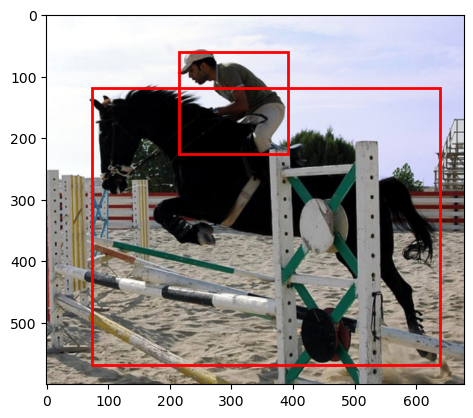

torch.Size([256, 36, 41])


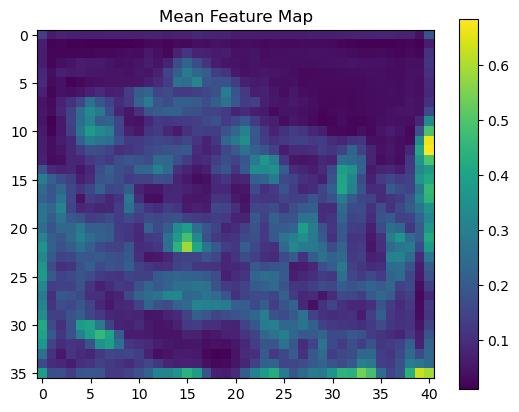

0.06047197640117994
tensor([[ 73.2240, 118.2960, 638.6760, 568.4880],
        [214.2480,  59.9880, 391.8840, 225.4200]])
tensor([[ 4.4280,  7.1536, 38.6220, 34.3776],
        [12.9560,  3.6276, 23.6980, 13.6316]])


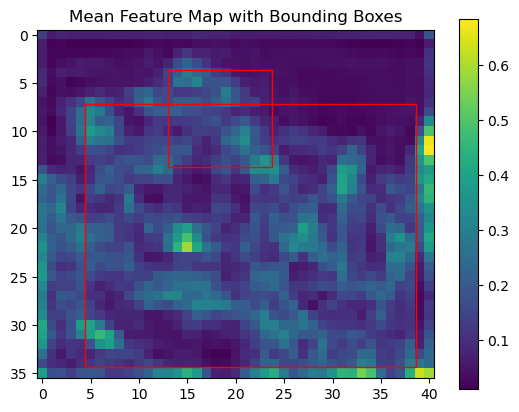

0.0625
tensor([[ 73.2240, 118.2960, 638.6760, 568.4880],
        [214.2480,  59.9880, 391.8840, 225.4200]])
tensor([[ 4.5765,  7.3935, 39.9172, 35.5305],
        [13.3905,  3.7492, 24.4927, 14.0887]])


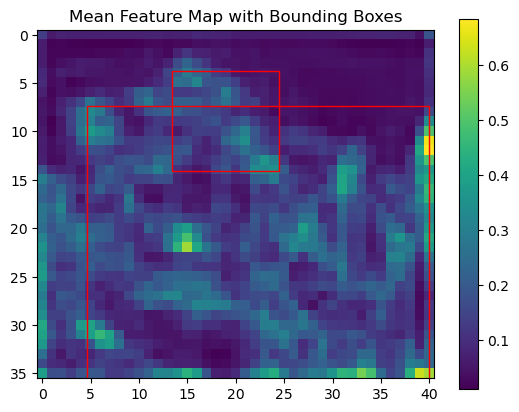

In [14]:
# Creiamo un'istanza del modello

model = Backbone()

model.eval()
image, img_size, gt_class, gt_bbox, gt_attributes, ss_rois = train_data[0]
show_image_with_boxes(image, gt_bbox, mean, std)
# Esegui il forward pass per ottenere la feature map
with torch.no_grad():
    features = model(image)
    print(features.shape)

# Converti la feature map in numpy per la visualizzazione
feature_map = (
    features.squeeze(0).cpu().numpy()
)  # Squeeze per rimuovere la dimensione del batch


# Visualizza la feature map
plt.imshow(
    torch.mean(features, dim=0), cmap="viridis"
)  # Mostra solo il primo canale della feature map
plt.colorbar()
plt.title("Mean Feature Map")
plt.show()

scale_factor = features.size(-1) / image.size(-1)
print(scale_factor)
print(gt_bbox)
# Adatta le bounding box originali alla dimensione della feature map
scaled_bboxes = gt_bbox * scale_factor
print(scaled_bboxes)

# Visualizza la feature map
plt.imshow(
    torch.mean(features, dim=0), cmap="viridis"
)  # Mostra solo il primo canale della feature map

# Disegna le bounding box sulla feature map
for bbox in scaled_bboxes:
    xmin, ymin, xmax, ymax = bbox
    rect = plt.Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
    plt.gca().add_patch(rect)

plt.colorbar()
plt.title("Mean Feature Map with Bounding Boxes")
plt.show()


scale_factor = 0.0625
print(scale_factor)
print(gt_bbox)
# Adatta le bounding box originali alla dimensione della feature map
scaled_bboxes = gt_bbox * scale_factor
print(scaled_bboxes)

# Visualizza la feature map
plt.imshow(
    torch.mean(features, dim=0), cmap="viridis"
)  # Mostra solo il primo canale della feature map

# Disegna le bounding box sulla feature map
for bbox in scaled_bboxes:
    xmin, ymin, xmax, ymax = bbox
    rect = plt.Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
    plt.gca().add_patch(rect)

plt.colorbar()
plt.title("Mean Feature Map with Bounding Boxes")
plt.show()

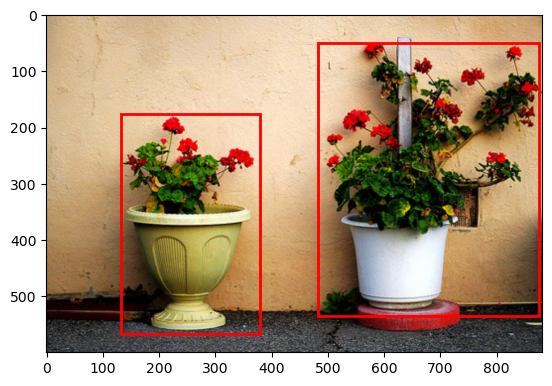

torch.Size([256, 36, 54])


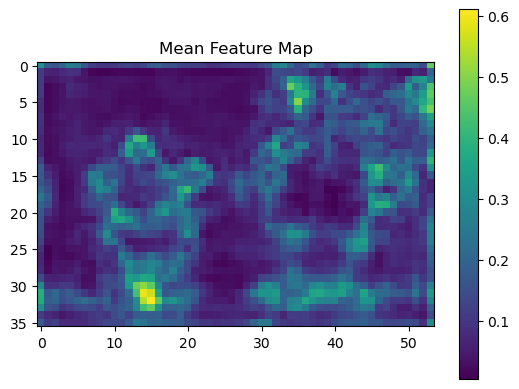

0.0625
tensor([[132.3000, 176.5200, 379.2600, 566.3640],
        [483.3360,  49.5120, 874.9440, 534.6120]])
tensor([[ 8.2687, 11.0325, 23.7037, 35.3978],
        [30.2085,  3.0945, 54.6840, 33.4132]])


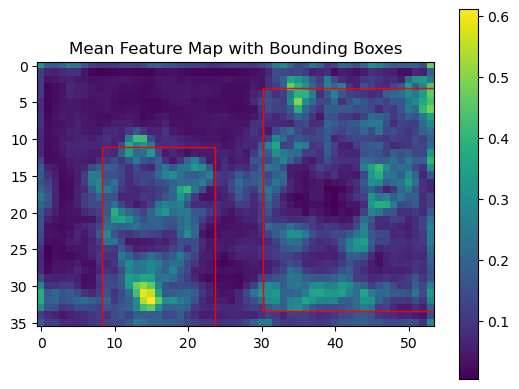

0.061224489795918366
tensor([[132.3000, 176.5200, 379.2600, 566.3640],
        [483.3360,  49.5120, 874.9440, 534.6120]])
tensor([[ 8.1000, 10.8073, 23.2200, 34.6753],
        [29.5920,  3.0313, 53.5680, 32.7313]])


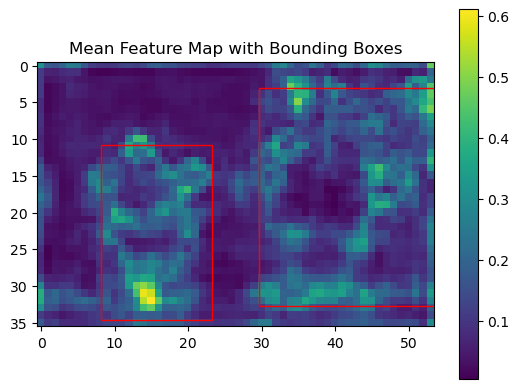

In [15]:
ind = torch.randint(0, 100, (1,)).item()


for i, (image, img_size, gt_class, gt_bbox, gt_attributes, ss_rois) in enumerate(
    train_data
):
    if i == ind:
        # Creiamo un'istanza del modello

        model = Backbone()

        model.eval()
        show_image_with_boxes(image, gt_bbox, mean, std)
        # Esegui il forward pass per ottenere la feature map
        with torch.no_grad():
            features = model(image)
            print(features.shape)

        # Converti la feature map in numpy per la visualizzazione
        feature_map = (
            features.squeeze(0).cpu().numpy()
        )  # Squeeze per rimuovere la dimensione del batch

        # Visualizza la feature map
        plt.imshow(
            torch.mean(features, dim=0), cmap="viridis"
        )  # Mostra solo il primo canale della feature map
        plt.colorbar()
        plt.title("Mean Feature Map")
        plt.show()

        scale_factor = 0.0625
        print(scale_factor)
        print(gt_bbox)
        # Adatta le bounding box originali alla dimensione della feature map
        scaled_bboxes = gt_bbox * scale_factor
        print(scaled_bboxes)

        # Visualizza la feature map
        plt.imshow(
            torch.mean(features, dim=0), cmap="viridis"
        )  # Mostra solo il primo canale della feature map

        # Disegna le bounding box sulla feature map
        for bbox in scaled_bboxes:
            xmin, ymin, xmax, ymax = bbox
            rect = plt.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=1,
                edgecolor="r",
                facecolor="none",
            )
            plt.gca().add_patch(rect)

        plt.colorbar()
        plt.title("Mean Feature Map with Bounding Boxes")
        plt.show()

        scale_factor = features.size(-1) / image.size(-1)
        print(scale_factor)
        print(gt_bbox)
        # Adatta le bounding box originali alla dimensione della feature map
        scaled_bboxes = gt_bbox * scale_factor
        print(scaled_bboxes)

        # Visualizza la feature map
        plt.imshow(
            torch.mean(features, dim=0), cmap="viridis"
        )  # Mostra solo il primo canale della feature map

        # Disegna le bounding box sulla feature map
        for bbox in scaled_bboxes:
            xmin, ymin, xmax, ymax = bbox
            rect = plt.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=1,
                edgecolor="r",
                facecolor="none",
            )
            plt.gca().add_patch(rect)

        plt.colorbar()
        plt.title("Mean Feature Map with Bounding Boxes")
        plt.show()

        break

In [1]:
for ind, (image, train_roi, train_cls, train_offset, _, indices_batch) in enumerate(
    train_dataloader
):
    for i in range(len(image)):
        # Creiamo un'istanza del modello

        model = Backbone()
        index_current_images = (indices_batch == i).squeeze(-1)
        model.eval()
        filtered_rois = train_roi[index_current_images]
        filtered_cls = train_cls[index_current_images]
        filtered_indices = filtered_cls > 0
        final_rois = filtered_rois[filtered_indices]

        show_image_with_boxes(image[i], final_rois, mean, std)
        # Esegui il forward pass per ottenere la feature map
        with torch.no_grad():
            print(image[i].shape)
            features = model(image[i])

            print(features.shape)

        """# Converti la feature map in numpy per la visualizzazione
        feature_map = (
            features.squeeze(0).cpu().numpy()
        )  # Squeeze per rimuovere la dimensione del batch

        # Visualizza la feature map
        plt.imshow(
            torch.mean(features, dim=0), cmap="viridis"
        )  # Mostra solo il primo canale della feature map
        plt.colorbar()
        plt.title("Mean Feature Map")
        plt.show()
        """
        scale_factor = 0.0625
        # Adatta le bounding box originali alla dimensione della feature map
        scaled_bboxes = final_rois * scale_factor

        # Visualizza la feature map
        plt.imshow(
            torch.mean(features, dim=0), cmap="viridis"
        )  # Mostra solo il primo canale della feature map

        # Disegna le bounding box sulla feature map
        for bbox in scaled_bboxes:
            xmin, ymin, xmax, ymax = bbox
            rect = plt.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=1,
                edgecolor="r",
                facecolor="none",
            )
            plt.gca().add_patch(rect)

        plt.colorbar()
        plt.title("Mean Feature Map with Bounding Boxes")
        plt.show()
        break

NameError: name 'train_dataloader' is not defined

torch.Size([1, 256, 36, 56])
tensor([[8.4750e+00, 3.3255e+00, 2.4238e+01, 1.3919e+01],
        [1.6611e+01, 5.2747e+00, 2.5171e+01, 1.4089e+01],
        [1.6950e+01, 5.0205e+00, 2.4238e+01, 1.4258e+01],
        [0.0000e+00, 2.0250e-02, 4.2375e+01, 3.7480e+01],
        [0.0000e+00, 1.2902e+01, 4.2375e+01, 3.7480e+01],
        [1.7204e+01, 5.0205e+00, 2.4238e+01, 1.3919e+01],
        [1.6272e+01, 4.6815e+00, 2.5171e+01, 1.4089e+01],
        [0.0000e+00, 3.6645e+00, 3.1103e+01, 3.7480e+01],
        [0.0000e+00, 5.0205e+00, 3.1273e+01, 3.7480e+01],
        [8.4750e+00, 3.3255e+00, 2.5255e+01, 1.4936e+01],
        [1.3984e+01, 4.8510e+00, 2.4238e+01, 1.3919e+01],
        [9.0682e+00, 2.7322e+00, 2.4154e+01, 1.1377e+01],
        [9.0682e+00, 3.6645e+00, 2.4154e+01, 1.1377e+01],
        [0.0000e+00, 5.0205e+00, 4.2375e+01, 3.7480e+01],
        [8.3055e+00, 8.0715e+00, 4.2375e+01, 3.7480e+01]])


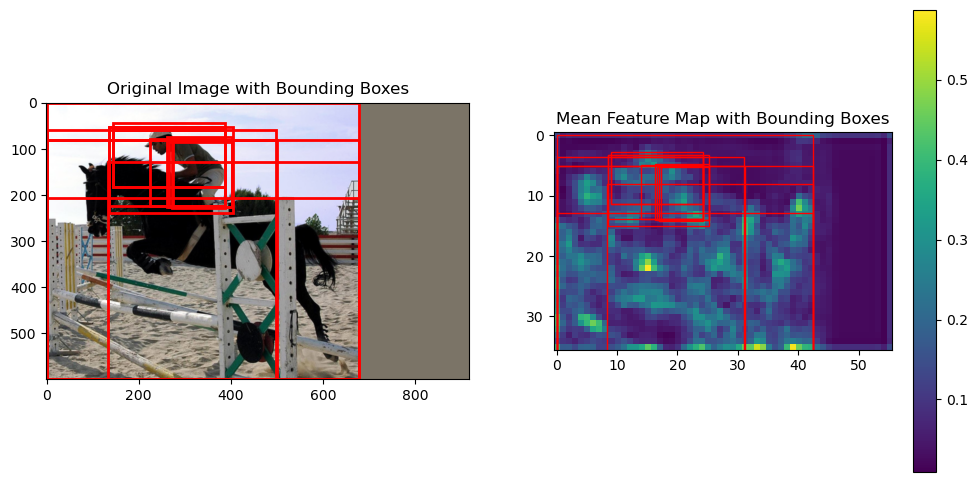

torch.Size([1, 256, 55, 61])
tensor([[51.3021,  1.8333, 62.5000, 13.6823],
        [16.6667, 10.5573, 44.4010, 35.4271],
        [16.6667,  2.2240, 49.6094, 35.4271],
        [47.9167,  2.0938, 62.5000, 13.6823],
        [46.8750,  2.2240, 62.5000, 10.0365],
        [25.6510, 10.0365, 40.6250, 29.0469],
        [25.6510, 10.0365, 42.3177, 33.4740],
        [51.3021,  2.0938, 62.5000, 13.6823],
        [16.6667,  1.4427, 49.6094, 35.4271]])


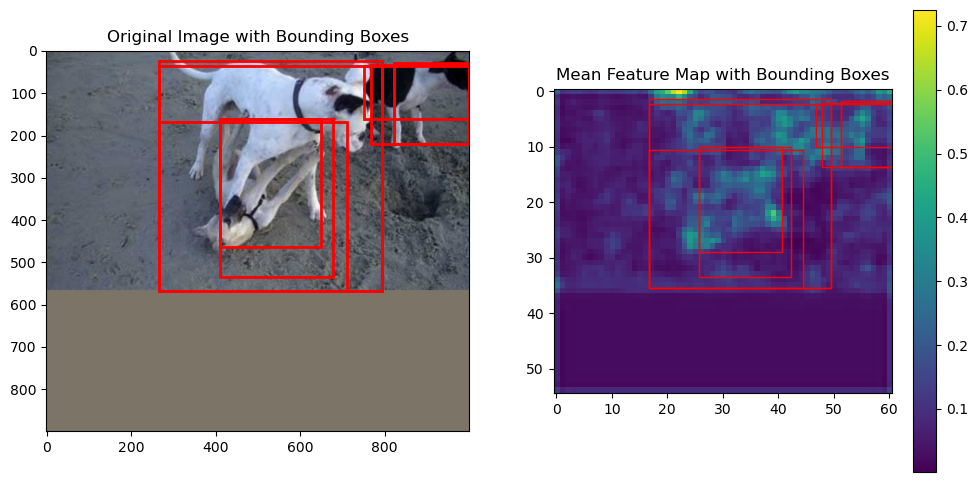

torch.Size([1, 256, 36, 55])
tensor([[40.7000, 19.9000, 45.3000, 22.6000],
        [24.5000, 19.7000, 34.2000, 23.7000],
        [24.5000, 18.8000, 34.2000, 23.7000],
        [40.7000, 20.7000, 45.3000, 23.7000],
        [27.0000, 21.9000, 34.2000, 24.0000],
        [40.7000, 20.5000, 45.7000, 23.6000],
        [27.0000, 19.7000, 34.2000, 24.0000],
        [27.0000, 19.7000, 33.8000, 22.8000],
        [40.7000, 20.3000, 46.2000, 22.4000],
        [27.0000, 21.2000, 34.2000, 24.0000]])


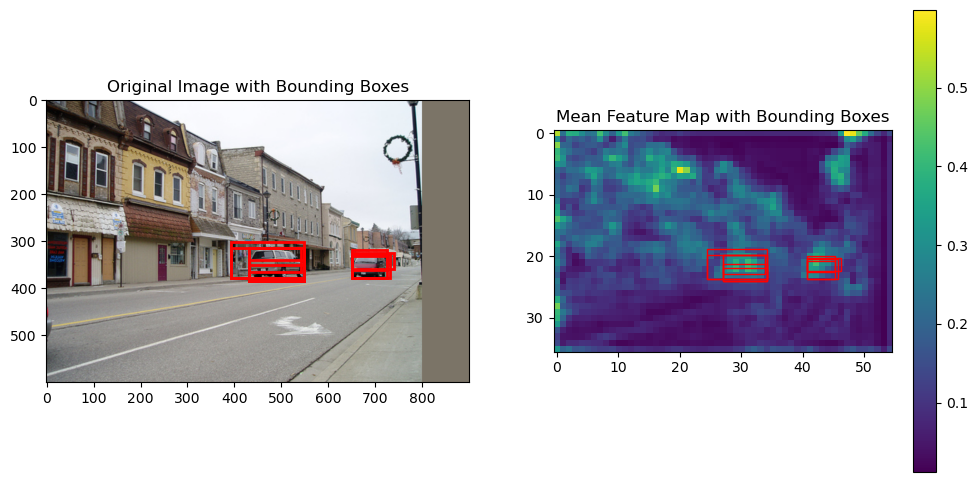

torch.Size([1, 256, 36, 49])
tensor([[ 0.0000,  0.9000, 50.0000, 26.5000],
        [21.9000, 12.3000, 39.3000, 23.3000],
        [12.7000,  1.4000, 20.5000,  3.7000],
        [11.8000,  0.0000, 20.5000,  3.7000],
        [14.7000,  3.2000, 28.7000, 12.8000],
        [ 0.0000,  0.0000, 50.0000, 26.5000],
        [ 0.0000,  0.5000, 29.6000, 17.7000],
        [12.7000,  0.0000, 20.5000,  3.7000],
        [ 0.0000,  0.9000, 50.0000, 24.6000],
        [12.5000,  3.0000, 29.4000, 11.8000],
        [15.3000,  3.1000, 28.8000, 11.8000],
        [ 0.0000,  0.0000, 32.2000, 22.8000],
        [ 0.0000,  0.0000, 32.2000, 19.0000],
        [ 6.8000, 21.6000, 50.0000, 27.7000],
        [11.8000,  0.0000, 25.4000,  3.7000]])


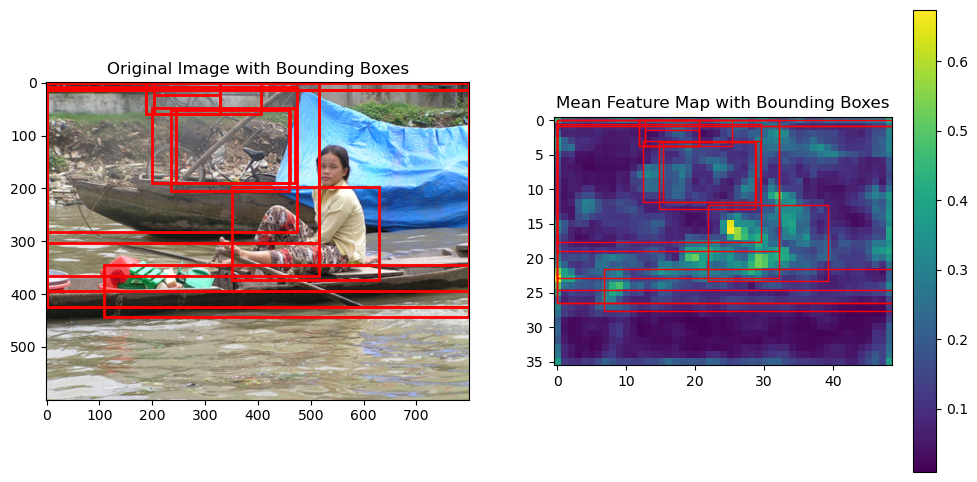

torch.Size([1, 256, 36, 49])
tensor([[16.1000, 18.9000, 21.0000, 23.3000],
        [ 2.8000, 22.1000, 12.8000, 35.9000],
        [10.3000, 17.6000, 18.9000, 22.9000],
        [29.5000, 19.2000, 38.4000, 32.5000],
        [ 0.0000, 17.6000,  6.2000, 29.7000],
        [ 6.5000, 27.6000, 13.1000, 35.7000],
        [ 2.5000, 22.1000, 15.8000, 37.0000],
        [ 2.9000, 23.8000, 14.4000, 37.5000],
        [ 0.0000, 17.5000,  8.5000, 26.8000],
        [20.3000, 27.6000, 28.0000, 37.5000],
        [ 0.4000, 19.2000,  6.2000, 23.9000],
        [14.2000, 27.7000, 22.5000, 37.5000],
        [ 4.1000, 25.1000, 12.6000, 35.9000],
        [10.0000, 19.4000, 30.5000, 37.5000],
        [ 6.1000, 25.1000, 15.2000, 35.2000],
        [18.4000, 26.3000, 31.2000, 37.5000],
        [ 3.7000, 23.0000, 12.6000, 35.9000],
        [16.7000, 24.9000, 34.9000, 32.4000],
        [ 0.0000, 22.1000, 15.8000, 37.0000],
        [17.7000, 19.0000, 20.4000, 22.1000],
        [25.4000, 18.0000, 28.2000, 23.6000],
     

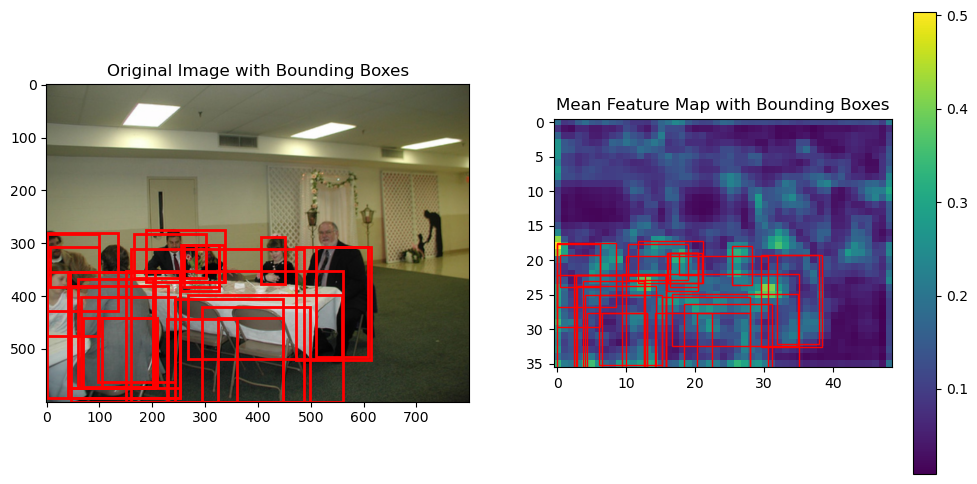

torch.Size([1, 256, 36, 49])
tensor([[ 0.0000,  0.0000, 50.0000, 37.5000],
        [ 5.6000,  0.0000, 50.0000, 37.5000],
        [ 5.6000,  0.0000, 36.7000, 29.6000],
        [ 6.2000,  0.0000, 49.0000, 37.5000],
        [11.2000,  0.0000, 50.0000, 37.5000],
        [ 0.0000,  0.0000, 47.6000, 37.5000],
        [ 3.8000,  2.9000, 33.0000, 34.4000],
        [ 6.2000,  0.0000, 50.0000, 37.5000],
        [ 6.2000,  0.0000, 35.7000, 37.5000],
        [17.8000,  0.0000, 47.6000, 35.7000],
        [ 5.6000,  0.0000, 36.7000, 27.5000],
        [ 3.8000,  0.0000, 50.0000, 37.5000],
        [ 5.6000,  0.0000, 37.4000, 37.5000],
        [ 0.0000,  0.0000, 37.4000, 37.5000],
        [ 3.8000,  0.0000, 39.9000, 34.4000]])


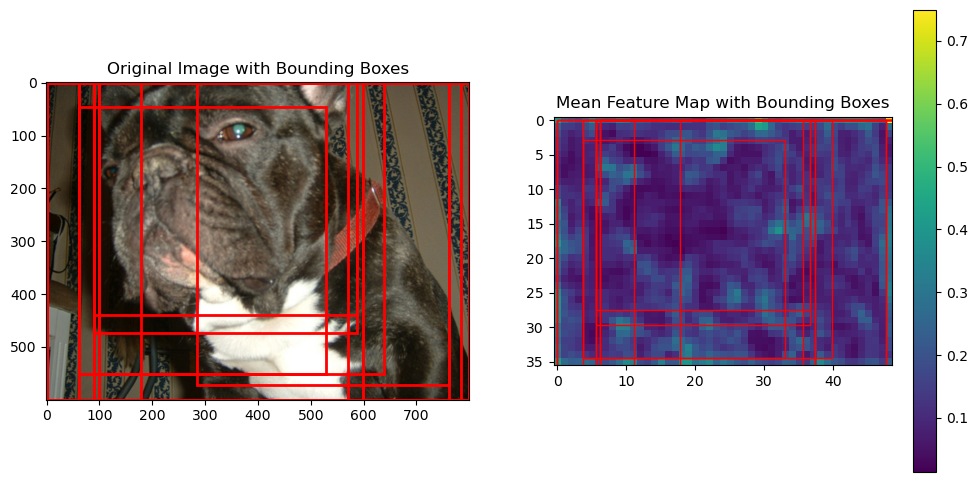

KeyboardInterrupt: 

In [17]:
# Supponiamo che show_image_with_boxes sia una funzione che mostra l'immagine con le bounding box
# e Backbone sia il modello della rete neurale


def show_image_with_boxes(image_tensor, boxes, mean, std, ax=None):
    # Denormalizzare l'immagine
    image = denormalize(image_tensor, mean, std)
    image = image.numpy().transpose((1, 2, 0))  # Convertire da (C, H, W) a (H, W, C)

    if ax is None:
        fig, ax = plt.subplots(1)

    ax.imshow(image)

    # Aggiungere i bounding box
    for box in boxes:
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle(
            (x1, y1), width, height, linewidth=2, edgecolor="r", facecolor="none"
        )
        ax.add_patch(rect)

    if ax is None:
        plt.show()


for ind, (image, train_roi, train_cls, train_offset, _, indices_batch) in enumerate(
    train_dataloader
):
    for i in range(len(image)):
        # Creiamo un'istanza del modello
        model = Backbone()
        index_current_images = (indices_batch == i).squeeze(-1)
        model.eval()
        filtered_rois = train_roi[index_current_images]
        filtered_cls = train_cls[index_current_images]
        filtered_indices = filtered_cls > 0
        final_rois = filtered_rois[filtered_indices]

        # Esegui il forward pass per ottenere la feature map
        with torch.no_grad():
            features = model(image[i].unsqueeze(0))  # Aggiungi una dimensione del batch
            print(features.shape)

        scale_factor = 0.0625
        # Adatta le bounding box originali alla dimensione della feature map
        scaled_bboxes = final_rois * scale_factor

        # Visualizzazione delle immagini e delle feature map fianco a fianco
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Mostra l'immagine originale con le bounding box
        ax = axes[0]
        show_image_with_boxes(image[i], final_rois, mean, std, ax=ax)
        ax.set_title("Original Image with Bounding Boxes")

        # Mostra la feature map con le bounding box scalate
        ax = axes[1]
        ax.imshow(torch.mean(features.squeeze(0), dim=0).cpu(), cmap="viridis")
        print(scaled_bboxes)
        # Disegna le bounding box sulla feature map
        for bbox in scaled_bboxes:
            xmin, ymin, xmax, ymax = bbox
            rect = plt.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=1,
                edgecolor="r",
                facecolor="none",
            )
            ax.add_patch(rect)

        ax.set_title("Mean Feature Map with Bounding Boxes")
        plt.colorbar(
            ax.imshow(torch.mean(features.squeeze(0), dim=0).cpu(), cmap="viridis"),
            ax=ax,
        )
        plt.show()
        break

In [ ]:
import torchvision